In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data analysis and wrangling
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from ipywidgets import interact

# machine learning 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,classification_report,make_scorer,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
import MyClassAndFun as MCF

In [2]:
df=pd.read_csv('transformed__dumm_train.csv')
df.drop(['id','customer_id','month','ssn_aaa','monthly_inhand_salary','delay_from_due_date'], axis=1, inplace=True)#,
       #  'num_credit_card','interest_rate'], axis=1, inplace=True)
X=df.drop('credit_score', axis=1)
y=df['credit_score']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=1,stratify=y)
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
transform_var_list=['age','annual_income','changed_credit_limit',#'delay_from_due_date',,'interest_rate'
                    'credit_utilization_ratio','credit_history_monts',#'outstanding_debt',
                    'num_of_delayed_payment','total_emi_per_month','amount_invested_monthly','monthly_balance',]
for i in transform_var_list:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.transform(X_test[[i]])
X_train_df=pd.DataFrame(X_train,columns=X.columns)
X_test_df=pd.DataFrame(X_test,columns=X.columns)
combined_df = pd.concat([X_train_df, y_train], axis=1)
test_results = MCF.perform_tests(combined_df)
# print(test_results.sort_values(by="t-statistic", ascending=False))
X_test_df=X_test_df[list(test_results.loc[test_results['p-value']==0].column)]
X_train_df=X_train_df[list(test_results.loc[test_results['p-value']==0].column)]
from imblearn.over_sampling import SMOTE

# Подсчет количества экземпляров каждого класса
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
# Вычисление на сколько увеличить каждый класс на 20%
sampling_strategy = {key: int(value * 1.2) for key, value in class_counts.items()}

# Создание объекта SMOTE с указанием sampling_strategy в виде словаря
smote = SMOTE(sampling_strategy=sampling_strategy)
X_train_df, y_train = smote.fit_resample(X_train_df, y_train)
#SMOTE
smote = SMOTE()
X_train_df, y_train = smote.fit_resample(X_train_df, y_train)

C:\Users\elper\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (63808) in class 1 will be larger than the number of samples in the majority class (class #1 -> 47857)
  warnings.warn(


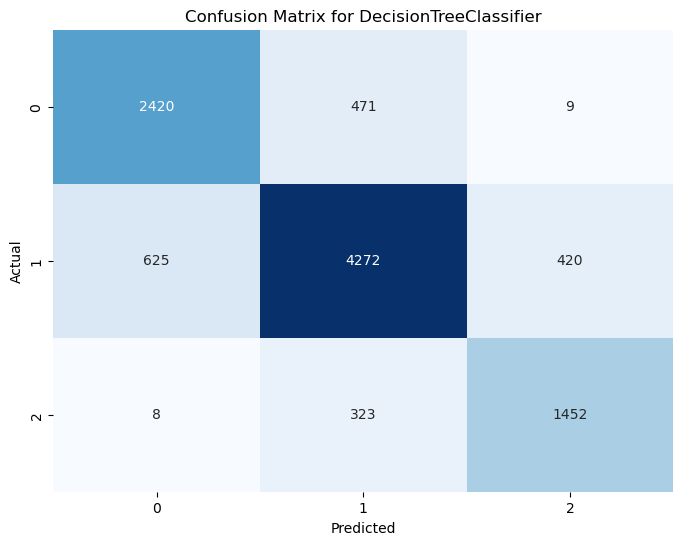

Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2900
           1       0.84      0.80      0.82      5317
           2       0.77      0.81      0.79      1783

    accuracy                           0.81     10000
   macro avg       0.80      0.82      0.81     10000
weighted avg       0.82      0.81      0.81     10000



In [3]:
DecisionTree_C=DecisionTreeClassifier(criterion='entropy', max_depth=30)

DecisionTree_C.set_params(random_state=1)
DecisionTree_C.fit(X_train_df, y_train)
DecisionTree_pred = DecisionTree_C.predict(X_test_df)
confusion = confusion_matrix(y_test, DecisionTree_pred)
report = classification_report(y_test, DecisionTree_pred)

# Plot a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for DecisionTreeClassifier')
plt.show()

# Print the classification report
print(f"Classification Report for DecisionTreeClassifier:\n")
print(report)

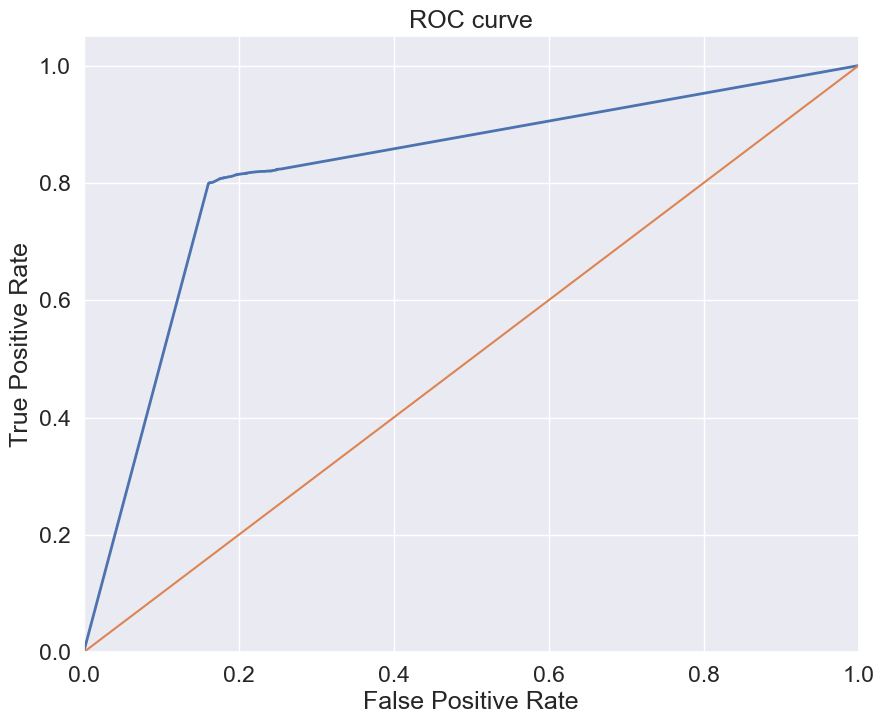

In [4]:
MCF.ROC_curve(DecisionTree_C,X_test_df,y_test)

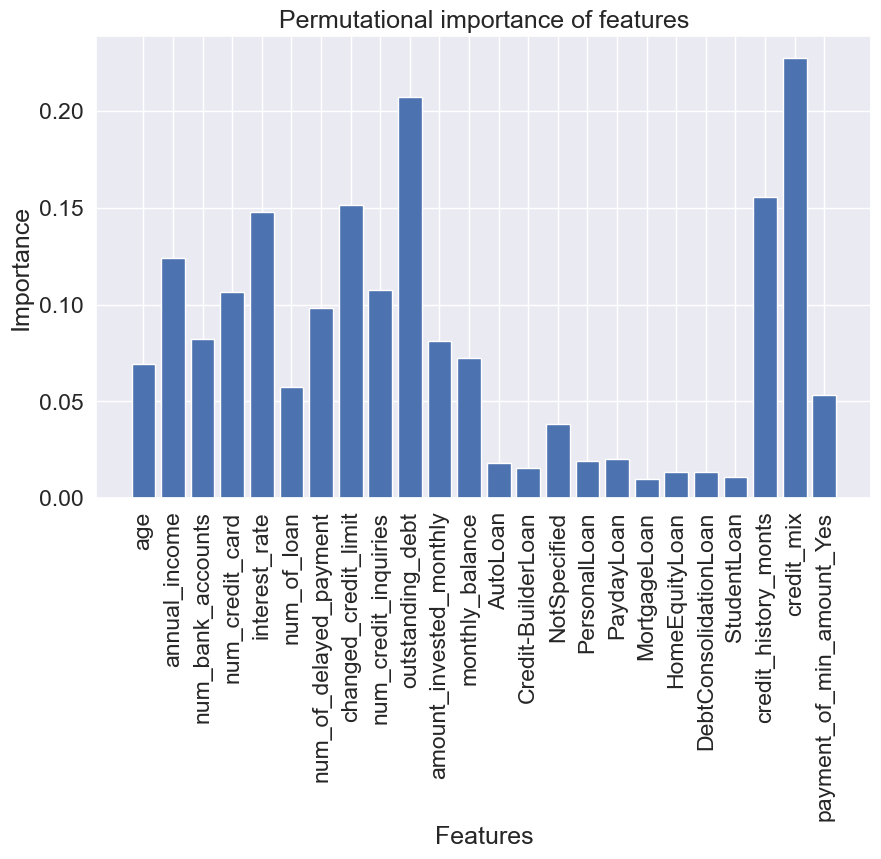

In [5]:
MCF.Perm_import(DecisionTree_C,X_test_df,y_test)

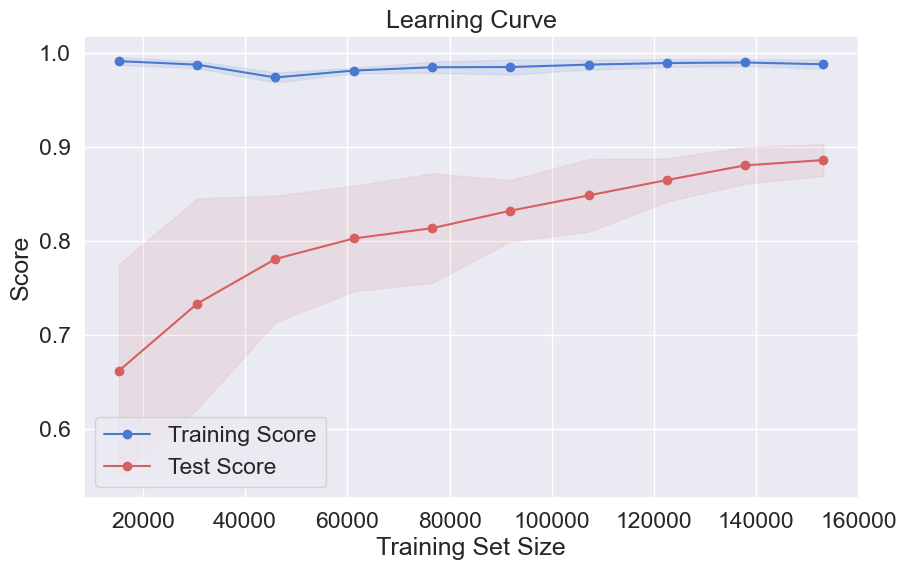

In [6]:
train_sizes = np.linspace(0.1, 1.0, 10)  

MCF.plot_learning_curve(DecisionTree_C, X_train_df, y_train, X_test_df, y_test, train_sizes)
